In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
train_terms = pd.read_csv("Train/train_terms.tsv",sep="\t")
print(train_terms.shape)
train_terms.head()

(5363863, 3)


,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [3]:
train_protein_ids = np.load('train_ids.npy')
print(train_protein_ids.shape)
print(train_protein_ids[:5])

train_embeddings = np.load('train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)
train_df.head()

(142246,)
['P20536' 'O73864' 'O95231' 'A0A0B4J1F4' 'P54366']
(142246, 1024)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


(31466,)


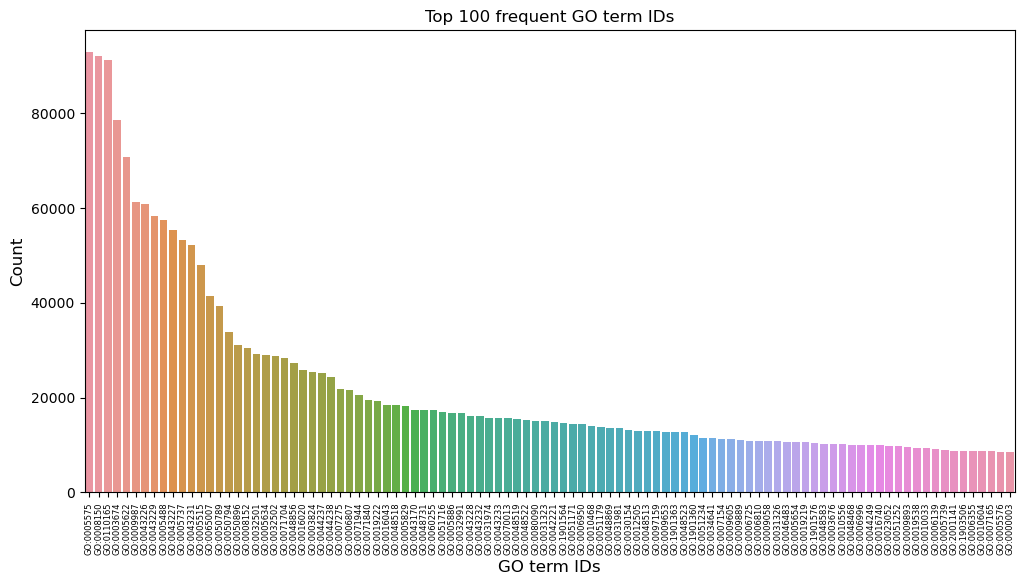

In [4]:
print(train_terms['term'].value_counts().shape)

# Select first 1500 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

(3603814, 3)


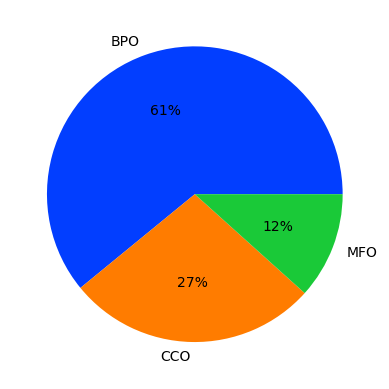

In [5]:
# Set the limit for label
num_of_labels = 500

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]
print(train_terms_updated.shape)

pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

In [6]:
# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in tqdm(range(num_of_labels)):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]

    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()

    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)
labels_df.head()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:35<00:00,  5.22it/s]

(142246, 500)


,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0140657,GO:0044297,GO:0030659,GO:0051129,GO:0099568,GO:0044403,GO:0042803,GO:0016829,GO:0090596,GO:0051640
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0140657,GO:0044297,GO:0030659,GO:0051129,GO:0099568,GO:0044403,GO:0042803,GO:0016829,GO:0090596,GO:0051640
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [8]:
labels_df.to_csv('labels_df.csv')

In [9]:
labels_df

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0140657,GO:0044297,GO:0030659,GO:0051129,GO:0099568,GO:0044403,GO:0042803,GO:0016829,GO:0090596,GO:0051640
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142242,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142243,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142244,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


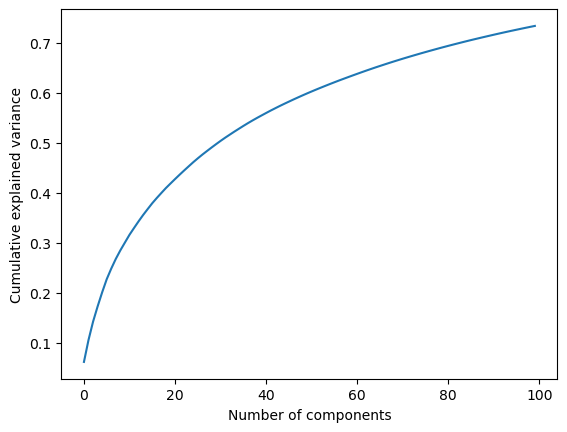

Selected DataFrame:
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0       0.302085 -0.455858 -0.422025 -0.611852 -0.235776 -0.604621 -0.090297   
1      -0.088110  0.044121 -0.475973 -0.641307 -0.164428 -0.520182 -0.243003   
2       0.146331  0.782726 -0.258063 -0.507131 -0.091898 -0.079294 -0.278577   
3      -0.319369  0.388843 -0.371338 -0.568892 -0.303159 -0.468241 -0.174299   
4       0.386561  0.190544  0.578516 -0.378255 -0.164848 -0.524811 -0.354166   
...          ...       ...       ...       ...       ...       ...       ...   
142241  0.160410 -0.031506 -0.205110 -0.513537 -0.341970 -0.127773 -0.374297   
142242 -0.292800  0.134196 -0.128518 -0.554576 -0.278087 -0.608426 -0.002074   
142243  0.035529  0.061609 -0.352233 -0.612996 -0.320888 -0.519959 -0.053006   
142244 -0.309099  0.220550  0.113141 -0.407171 -0.079802 -0.637065 -0.203742   
142245 -0.305441 -0.144999 -0.304606 -0.500692 -0.104708 -0.547035 -0.168119   

             PC8   

In [10]:
# PCA 1024 to 100:
def apply_pca(data, num_components):
    # Standardize the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Apply PCA
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(scaled_data)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.show()
    # Apply Min-Max scaling to the PCA output
    min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_pca_result = min_max_scaler.fit_transform(pca_result)

    # Create a new DataFrame with the scaled PCA features
    pca_df = pd.DataFrame(scaled_pca_result, columns=[f"PC{i+1}" for i in range(num_components)])

    return pca_df

# Assuming you have a DataFrame 'train_df' with features
num_components = 100  # Specify the number of components

# Apply PCA with the specified number of components and standardize to [-1, 1]
pca_result_df = apply_pca(train_df, num_components)

print("Selected DataFrame:")
print(pca_result_df)

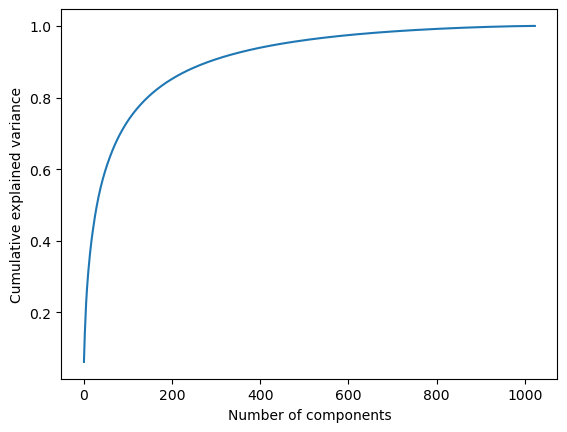

Number of components retained: 285


In [20]:
#PCA with threshold:
def apply_pca_with_threshold(data, threshold):
    # Standardize the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Apply PCA
    pca = PCA()
    pca_result = pca.fit_transform(scaled_data)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.show()
    # Get the explained variance ratios
    explained_variance_ratio = pca.explained_variance_ratio_

    # Determine the number of components to retain based on the threshold
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    num_components = np.argmax(cumulative_explained_variance >= threshold) + 1

    # Fit PCA with the selected number of components
    pca_selected = PCA(n_components=num_components)
    pca_result_selected = pca_selected.fit_transform(scaled_data)

    # Transform the selected components back to the original space
    selected_features = pca_selected.inverse_transform(pca_result_selected)

    # Create a DataFrame with the selected features
    selected_df = pd.DataFrame(data=selected_features, columns=data.columns)

    # Identify the dropped columns
    dropped_columns = data.columns.difference(selected_df.columns)

    pca_threshold = pd.DataFrame(data=selected_features, columns=train_df.columns)

    return num_components, dropped_columns, pca_threshold

threshold = 0.9

# Apply PCA with the specified threshold
num_components_retained, dropped_columns, pca_threshold_df = apply_pca_with_threshold(train_df, threshold)
print("Number of components retained:", num_components_retained)
# print(pca_threshold_df)



In [12]:
labels = labels_df.idxmax(axis=1)

# Step 3: Initialize and fit the LDA model
n_components = min(train_df.shape[1], len(labels.unique())) - 1
# Ensuring n_components is within the allowed range
lda = LinearDiscriminantAnalysis(n_components=n_components)
lda.fit(train_df, labels)

# Step 4: Get the transformed dataset
transformed_data = lda.transform(train_df)

# Create a DataFrame with the transformed features
transformed_df = pd.DataFrame(transformed_data, columns=[f"LD{i+1}" for i in range(n_components)])

# Display the first few rows of the transformed dataset
print(transformed_df.head())


        LD1       LD2
0 -1.706598 -0.672916
1 -1.234371  2.716611
2 -0.023151 -0.897010
3  1.370625 -1.683052
4 -0.613292  2.730387


###### Normal: 16s 4ms/step - loss: 0.6095 - binary_accuracy: 0.9501 - auc_2: 0.8733, Overall Accuracy: 0.9501384496688843

###### PCA1: 13s 3ms/step - loss: 0.1636 - binary_accuracy: 0.9546 - auc: 0.8980, Overall Accuracy: 0.9546279907226562

###### PCA2: 14s 3ms/step - loss: 0.1226 - binary_accuracy: 0.9568 - auc: 0.9173, Overall Accuracy: 0.9567741751670837

###### LDA: 13s 3ms/step - loss: 0.1585 - binary_accuracy: 0.9525 - auc: 0.8141, Overall Accuracy: 0.9524716138839722